In [1]:
import cuml
# GPU acceleration for scikit learn (Makes machine learning much faster)
%load_ext cuml.accel

[2025-07-25 15:40:05.037] [CUML] [warning] cuML: Could not enable managed memory.
[2025-07-25 15:40:05.053] [CUML] [info] cuML: Installed accelerator for sklearn.
[2025-07-25 15:40:05.053] [CUML] [info] cuML: Successfully initialized accelerator.


In [2]:
%env NX_CUGRAPH_AUTOCONFIG=True
import networkx as nx

env: NX_CUGRAPH_AUTOCONFIG=True


### Exploring a simple problem



In [39]:
# # Parameters
# D = 10  # Travel time for required arcs
# S = 5   # Normal service time
# Z = 12  # Zigzag service time

# # Optional arc travel times (dashed lines)
# optional_arc_times = {
#     (0, 4): 10,
#     (4, 1): 8,
#     (2, 1): 5,
#     (4,0): 12
# }

# # Nodes and depot
# nodes = [0, 1, 2, 3, 4]
# depot = 0

# # Graph definition
# graph = {
#     "nodes": nodes,
#     "depot": depot,
#     "edges": {}
# }

# # Add required arcs (solid lines)
# for i in range(len(nodes)):
#     next_node = (i + 1) % len(nodes)
#     graph["edges"][(i, next_node)] = {
#         "travel_time": D,
#         "service_time_normal": S,
#         "service_time_zigzag": Z,
#         "required": True
#     }
#     graph["edges"][(next_node, i)] = {
#         "travel_time": D,
#         "service_time_normal": S,
#         "service_time_zigzag": Z,
#         "required": True
#     }
# # Add optional arcs (dashed lines)
# for (u, v), travel_time in optional_arc_times.items():
#     graph["edges"][(u, v)] = {
#         "travel_time": travel_time,
#         "required": False
#     }

# # Output the graph
# display(graph)


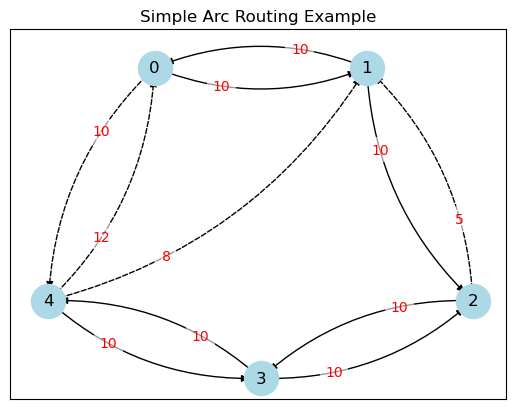

In [40]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(graph):
    G = nx.MultiDiGraph()

    # Add nodes
    for node in graph["nodes"]:
        G.add_node(node)
    
    # Add edges
    for (u, v), attrs in graph["edges"].items():
        label = attrs.get("travel_time", "")
        G.add_edge(u, v, label=label, **attrs)

    # Layout
    pos = {0: (-0.5, 2), 1: (0.5, 2), 
           2: (1, 0.5), 3: (0, 0), 4: (-1, 0.5)}

    # Draw nodes and labels
    nx.draw_networkx_nodes(G, pos, node_size=600, node_color='lightblue')
    nx.draw_networkx_labels(G, pos)

    # Draw edges with separate styles
    for u, v, k, data in G.edges(keys=True, data=True):
        edge_style = 'solid' if data['required'] else 'dashed'
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], style=edge_style,
                                 connectionstyle=f"arc3, rad={(0.2 if k == 0 else -0.2)}")


    # Draw edge labels with adjusted positions
    for u, v, k, data in G.edges(keys=True, data=True):
        label_pos = 0.2 if k == 0 else -0.2
        edge_label = {(u, v): data['label']}
        nx.draw_networkx_edge_labels(G, pos,
                                      edge_labels=edge_label,
                                      font_color='red',
                                      label_pos=0.3,
                                      rotate=False,
                                      bbox=dict(facecolor='white', edgecolor='none', alpha=0.6),
                                      connectionstyle=f"arc3,rad={label_pos}")

    plt.title("Simple Arc Routing Example")
    plt.show()

# Call the function
visualize_graph(graph)


In [41]:
graph

{'nodes': [0, 1, 2, 3, 4],
 'depot': 0,
 'edges': {(0, 1): {'travel_time': 10,
   'service_time_normal': 5,
   'service_time_zigzag': 12,
   'required': True},
  (1, 0): {'travel_time': 10,
   'service_time_normal': 5,
   'service_time_zigzag': 12,
   'required': True},
  (1, 2): {'travel_time': 10,
   'service_time_normal': 5,
   'service_time_zigzag': 12,
   'required': True},
  (2, 1): {'travel_time': 5, 'required': False},
  (2, 3): {'travel_time': 10,
   'service_time_normal': 5,
   'service_time_zigzag': 12,
   'required': True},
  (3, 2): {'travel_time': 10,
   'service_time_normal': 5,
   'service_time_zigzag': 12,
   'required': True},
  (3, 4): {'travel_time': 10,
   'service_time_normal': 5,
   'service_time_zigzag': 12,
   'required': True},
  (4, 3): {'travel_time': 10,
   'service_time_normal': 5,
   'service_time_zigzag': 12,
   'required': True},
  (4, 0): {'travel_time': 12, 'required': False},
  (0, 4): {'travel_time': 10, 'required': False},
  (4, 1): {'travel_time':

In [42]:
import numpy as np
import random
import math
from multiprocessing import Pool, cpu_count

# Problem Data (example)
nodes = [0, 1, 2, 3, 4]  # Node indices
depot = 0  # Starting point (depot)
edges = {
    (0, 1): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (1, 0): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (1, 2): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (2, 1): {'travel_time': 5, 'required': False},
    (2, 3): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (3, 2): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (3, 4): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (4, 3): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (4, 0): {'travel_time': 12, 'required': False},
    (0, 4): {'travel_time': 10, 'required': False},
    (4, 1): {'travel_time': 8, 'required': False}
}

# Function to calculate travel time for a route, including service time for required routes
def calculate_route_time(route):
    total_time = 0
    for i in range(len(route) - 1):
        u, v = route[i], route[i+1]
        
        # Check if the edge exists in the graph
        if (u, v) in edges:
            total_time += edges[(u, v)]['travel_time']
            if edges[(u, v)]['required']:
                total_time += edges[(u, v)]['service_time_normal']  # or another service time as needed
        
        elif (v, u) in edges:
            total_time += edges[(v, u)]['travel_time']
            if edges[(v, u)]['required']:
                total_time += edges[(v, u)]['service_time_normal']  # or another service time as needed
    return total_time

# Simulated Annealing algorithm (single chain)
def simulated_annealing(route, initial_temp=1000, cooling_rate=0.99, max_iterations=1000):
    current_route = route
    current_time = calculate_route_time(current_route)
    best_route = current_route
    best_time = current_time
    temp = initial_temp

    for iteration in range(max_iterations):
        # Generate a new neighbor solution by swapping two random nodes (excluding the depot)
        new_route = current_route.copy()
        i, j = random.sample(range(1, 
                                   len(route)-1), 
                             2)  # Ensure depot is not swapped
        new_route[i], new_route[j] = new_route[j], new_route[i]
        
        new_time = calculate_route_time(new_route)

        # Check if all required edges are in the route, if not, discard this route
        required_edges = [edge for edge in edges if edges[edge]['required']]
        if not all(edge in new_route for edge in required_edges):
            continue
        
        # Decide whether to accept the new solution
        if new_time < current_time or random.random() < math.exp((current_time - new_time) / temp):
            current_route = new_route
            current_time = new_time

        # Update the best solution found so far
        if current_time < best_time:
            best_route = current_route
            best_time = current_time

        # Decrease the temperature
        temp *= cooling_rate
    
    return best_route, best_time

# Wrapper for multiprocessing
def run_annealing_parallel(route):
    best_route, best_time = simulated_annealing(route)
    return best_route, best_time

# Main function for multiprocessing
def main():
    # Initialize a random route (example), but ensure the depot is the first node
    initial_route = nodes.copy()
    random.shuffle(initial_route)
    initial_route.remove(depot)
    initial_route = [depot] + initial_route

    # Define the number of processes (use all available CPUs minus 1)
    num_processes = cpu_count()-1

    # Create a pool of processes and run the Simulated Annealing algorithm in parallel
    with Pool(num_processes) as pool:
        results = pool.map(run_annealing_parallel, [initial_route] * num_processes)
    
    # Get the best result from the parallel executions
    best_route, best_time = min(results, key=lambda x: x[1])
    print(f"Best Route: {best_route}")
    print(f"Minimum Time: {best_time}")

if __name__ == "__main__":
    main()


Best Route: [0, 3, 1, 4, 2]
Minimum Time: 8


### Notes

- Simulated annealing is a metaheuristic often done with nodes based routing problem and less often with arc-based.

In [43]:
import random
import math
from collections import defaultdict

class ACO_ArcBased:
    def __init__(self, nodes, edges, depot, num_ants=10, num_iterations=100, alpha=1, beta=2, rho=0.1, q=100):
        self.nodes = nodes
        self.edges = edges
        self.depot = depot
        self.num_ants = num_ants
        self.num_iterations = num_iterations
        self.alpha = alpha  # Pheromone importance
        self.beta = beta    # Distance (or cost) importance
        self.rho = rho      # Pheromone evaporation rate
        self.q = q          # Constant for pheromone update
        
        # Initialize pheromone levels for all arcs
        self.pheromones = defaultdict(lambda: 1.0)  # Default pheromone for all edges
        
        # Keeps track of the service times (whether a given edge has been serviced)
        self.visited_arcs = defaultdict(bool)

    def calculate_route_time(self, route):
        total_time = 0
        for u, v in route:
            # Add travel time for the arc
            total_time += self.edges[(u, v)]['travel_time']
            
            # Check if it's a required arc and add service time if it's visited for the first time
            if self.edges[(u, v)]['required'] and not self.visited_arcs[(u, v)]:
                self.visited_arcs[(u, v)] = True
                total_time += self.edges[(u, v)]['service_time_normal']
        
        return total_time

    def select_next_arc(self, current_node, visited_nodes):
        # Calculate probabilities for each unvisited arc based on pheromones and distance
        probabilities = {}
        total_pheromone = 0
        for next_node in self.nodes:
            if next_node != current_node and (current_node, next_node) in self.edges and (current_node, next_node) not in visited_nodes:
                pheromone = self.pheromones[(current_node, next_node)] ** self.alpha
                distance = self.edges[(current_node, next_node)]['travel_time'] ** self.beta
                probability = pheromone / distance
                probabilities[(current_node, next_node)] = probability
                total_pheromone += probability
        
        # Normalize probabilities
        for arc in probabilities:
            probabilities[arc] /= total_pheromone
        
        # Select next arc based on the probability distribution
        return random.choices(list(probabilities.keys()), weights=probabilities.values())[0]

    def update_pheromones(self, ants_solutions):
        # Evaporate pheromones and deposit new pheromones
        for (u, v) in self.pheromones:
            self.pheromones[(u, v)] *= (1 - self.rho)  # Evaporate
        
        for solution, route_time in ants_solutions:
            pheromone_deposit = self.q / route_time
            for (u, v) in solution:
                self.pheromones[(u, v)] += pheromone_deposit

    def optimize(self):
        best_route = None
        best_time = float('inf')

        for iteration in range(self.num_iterations):
            ants_solutions = []
            
            for ant in range(self.num_ants):
                route = []
                visited_nodes = set([self.depot])
                current_node = self.depot
                
                while len(visited_nodes) < len(self.nodes):
                    next_arc = self.select_next_arc(current_node, visited_nodes)
                    route.append(next_arc)
                    visited_nodes.add(next_arc[1])
                    current_node = next_arc[1]
                
                route_time = self.calculate_route_time(route)
                ants_solutions.append((route, route_time))

                # Track the best route so far
                if route_time < best_time:
                    best_route = route
                    best_time = route_time

            # Update pheromones
            self.update_pheromones(ants_solutions)

        return best_route, best_time

# Problem Data (example)
nodes = [0, 1, 2, 3, 4]
depot = 0
edges = {
    (0, 1): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (1, 0): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (1, 2): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (2, 1): {'travel_time': 5, 'required': False},
    (2, 3): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (3, 2): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (3, 4): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (4, 3): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (4, 0): {'travel_time': 12, 'required': False},
    (0, 4): {'travel_time': 10, 'required': False},
    (4, 1): {'travel_time': 8, 'required': False}
}

# Example of using ACO for arc-based routing
aco = ACO_ArcBased(nodes, edges, depot)
best_route, best_time = aco.optimize()

print(f"Best Route: {best_route}")
print(f"Minimum Time: {best_time}")


Best Route: [(0, 4), (4, 3), (3, 2), (2, 1)]
Minimum Time: 35


### Notes

- Ant colony optimization, often it doesn't add to the route and only considers alterations to the current one.

In [44]:
import numpy as np
import random
import math
from multiprocessing import Pool, cpu_count

# Problem Data (example)
nodes = [0, 1, 2, 3, 4]  # Node indices
depot = 0  # Starting point (depot)
edges = {
    (0, 1): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (1, 0): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (1, 2): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (2, 1): {'travel_time': 5, 'required': False},
    (2, 3): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (3, 2): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (3, 4): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (4, 3): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (4, 0): {'travel_time': 12, 'required': False},
    (0, 4): {'travel_time': 10, 'required': False},
    (4, 1): {'travel_time': 8, 'required': False}
}

# Function to calculate travel time for a route, including service time for required routes
def calculate_route_time(route):
    total_time = 0
    for i in range(len(route) - 1):
        u, v = route[i], route[i+1]
        
        # Check if the edge exists in the graph
        if (u, v) in edges:
            total_time += edges[(u, v)]['travel_time']
            if edges[(u, v)]['required']:
                total_time += edges[(u, v)]['service_time_normal']  # or another service time as needed
        
        elif (v, u) in edges:
            total_time += edges[(v, u)]['travel_time']
            if edges[(v, u)]['required']:
                total_time += edges[(v, u)]['service_time_normal']  # or another service time as needed
    return total_time

# Simulated Annealing algorithm (single chain)
def simulated_annealing(route, initial_temp=1000, cooling_rate=0.99, max_iterations=1000):
    current_route = route
    current_time = calculate_route_time(current_route)
    best_route = current_route
    best_time = current_time
    temp = initial_temp

    for iteration in range(max_iterations):
        # Generate a new neighbor solution by swapping two random nodes (excluding the depot)
        new_route = current_route.copy()
        i, j = random.sample(range(1, 
                                   len(route)-1), 
                             2)  # Ensure depot is not swapped
        new_route[i], new_route[j] = new_route[j], new_route[i]
        
        new_time = calculate_route_time(new_route)

        # Check if all required edges are in the route, if not, discard this route
        required_edges = [edge for edge in edges if edges[edge]['required']]
        if not all(edge in new_route for edge in required_edges):
            continue
        
        # Decide whether to accept the new solution
        if new_time < current_time or random.random() < math.exp((current_time - new_time) / temp):
            current_route = new_route
            current_time = new_time

        # Update the best solution found so far
        if current_time < best_time:
            best_route = current_route
            best_time = current_time

        # Decrease the temperature
        temp *= cooling_rate
    
    return best_route, best_time

# Wrapper for multiprocessing
def run_annealing_parallel(route):
    best_route, best_time = simulated_annealing(route)
    return best_route, best_time

# Main function for multiprocessing
def main():
    # Initialize a random route (example), but ensure the depot is the first node
    initial_route = nodes.copy()
    random.shuffle(initial_route)
    initial_route.remove(depot)
    initial_route = [depot] + initial_route

    # Define the number of processes (use all available CPUs minus 1)
    num_processes = cpu_count()-1

    # Create a pool of processes and run the Simulated Annealing algorithm in parallel
    with Pool(num_processes) as pool:
        results = pool.map(run_annealing_parallel, [initial_route] * num_processes)
    
    # Get the best result from the parallel executions
    best_route, best_time = min(results, key=lambda x: x[1])
    print(f"Best Route: {best_route}")
    print(f"Minimum Time: {best_time}")

if __name__ == "__main__":
    main()


Best Route: [0, 2, 4, 3, 1]
Minimum Time: 15


In [45]:
edges

{(0, 1): {'travel_time': 10,
  'service_time_normal': 5,
  'service_time_zigzag': 12,
  'required': True},
 (1, 0): {'travel_time': 10,
  'service_time_normal': 5,
  'service_time_zigzag': 12,
  'required': True},
 (1, 2): {'travel_time': 10,
  'service_time_normal': 5,
  'service_time_zigzag': 12,
  'required': True},
 (2, 1): {'travel_time': 5, 'required': False},
 (2, 3): {'travel_time': 10,
  'service_time_normal': 5,
  'service_time_zigzag': 12,
  'required': True},
 (3, 2): {'travel_time': 10,
  'service_time_normal': 5,
  'service_time_zigzag': 12,
  'required': True},
 (3, 4): {'travel_time': 10,
  'service_time_normal': 5,
  'service_time_zigzag': 12,
  'required': True},
 (4, 3): {'travel_time': 10,
  'service_time_normal': 5,
  'service_time_zigzag': 12,
  'required': True},
 (4, 0): {'travel_time': 12, 'required': False},
 (0, 4): {'travel_time': 10, 'required': False},
 (4, 1): {'travel_time': 8, 'required': False}}

In [46]:
# Filter required paths using filter and lambda
required_edges = dict(filter(lambda item: item[1].get('required'), edges.items()))

# Display the required edges
for edge, properties in required_edges.items():
    print(f"Edge: {edge}, Properties: {properties}")

Edge: (0, 1), Properties: {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True}
Edge: (1, 0), Properties: {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True}
Edge: (1, 2), Properties: {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True}
Edge: (2, 3), Properties: {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True}
Edge: (3, 2), Properties: {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True}
Edge: (3, 4), Properties: {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True}
Edge: (4, 3), Properties: {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True}


In [47]:
required_edges

{(0, 1): {'travel_time': 10,
  'service_time_normal': 5,
  'service_time_zigzag': 12,
  'required': True},
 (1, 0): {'travel_time': 10,
  'service_time_normal': 5,
  'service_time_zigzag': 12,
  'required': True},
 (1, 2): {'travel_time': 10,
  'service_time_normal': 5,
  'service_time_zigzag': 12,
  'required': True},
 (2, 3): {'travel_time': 10,
  'service_time_normal': 5,
  'service_time_zigzag': 12,
  'required': True},
 (3, 2): {'travel_time': 10,
  'service_time_normal': 5,
  'service_time_zigzag': 12,
  'required': True},
 (3, 4): {'travel_time': 10,
  'service_time_normal': 5,
  'service_time_zigzag': 12,
  'required': True},
 (4, 3): {'travel_time': 10,
  'service_time_normal': 5,
  'service_time_zigzag': 12,
  'required': True}}

In [48]:
import numpy as np
import random
import math
from multiprocessing import Pool, cpu_count

# Problem Data (example)
nodes = [0, 1, 2, 3, 4]  # Node indices
depot = 0  # Starting point (depot)
edges = {
    (0, 1): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (1, 0): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (1, 2): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (2, 1): {'travel_time': 5, 'required': False},
    (2, 3): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (3, 2): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (3, 4): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (4, 3): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (4, 0): {'travel_time': 12, 'required': False},
    (0, 4): {'travel_time': 10, 'required': False},
    (4, 1): {'travel_time': 8, 'required': False}
}

# Function to calculate travel time for a route in terms of arcs (edges)
def calculate_route_time(route):
    total_time = 0
    for edge in route:
        u, v = edge
        
        # Check if the edge exists in the graph
        if (u, v) in edges:
            total_time += edges[(u, v)]['travel_time']
            if edges[(u, v)]['required']:
                total_time += edges[(u, v)]['service_time_normal']  # or another service time as needed
        
        elif (v, u) in edges:
            total_time += edges[(v, u)]['travel_time']
            if edges[(v, u)]['required']:
                total_time += edges[(v, u)]['service_time_normal']  # or another service time as needed
    return total_time

# Function to ensure all required edges are present in the route
def ensure_required_edges(route):
    required_edges = [edge for edge in edges if edges[edge]['required']]
    
    # Ensure required edges are included in the route
    included_edges = set(route)
    for edge in required_edges:
        if edge not in included_edges:
            # Add the required edge, maintaining a feasible path
            route.append(edge)
    return route

# Convert a node-based route to an arc-based route
def convert_to_arcs(route):
    return [(route[i], route[i+1]) for i in range(len(route)-1)]

# Simulated Annealing algorithm (single chain)
def simulated_annealing(route, initial_temp=1000, cooling_rate=0.99, max_iterations=1000):
    # Convert to arc-based representation
    current_route = convert_to_arcs(route)
    
    # Ensure required edges are in the route
    current_route = ensure_required_edges(current_route)
    
    current_time = calculate_route_time(current_route)
    best_route = current_route
    best_time = current_time
    temp = initial_temp

    for iteration in range(max_iterations):
        # Generate a new neighbor solution by swapping two random nodes (not arcs)
        new_route = route.copy()
        i, j = random.sample(range(1, len(new_route)), 2)  # Swap nodes, ensuring depot stays fixed
        new_route[i], new_route[j] = new_route[j], new_route[i]

        # Convert the new node-based route to arc-based
        new_route_arcs = convert_to_arcs(new_route)

        # Ensure required edges are preserved in the new route
        new_route_arcs = ensure_required_edges(new_route_arcs)
        
        new_time = calculate_route_time(new_route_arcs)

        # Decide whether to accept the new solution
        if new_time < current_time or random.random() < math.exp((current_time - new_time) / temp):
            route = new_route
            current_time = new_time

        # Update the best solution found so far
        if current_time < best_time:
            best_route = route
            best_time = current_time

        # Decrease the temperature
        temp *= cooling_rate
    
    # Convert the best route to arc format
    best_route_arcs = convert_to_arcs(best_route)
    best_route_arcs = ensure_required_edges(best_route_arcs)

    return best_route_arcs, best_time

# Wrapper for multiprocessing
def run_annealing_parallel(route):
    best_route, best_time = simulated_annealing(route)
    return best_route, best_time

# Main function for multiprocessing
def main():
    # Initialize a random route (example), but ensure the depot is the first node
    initial_route = nodes.copy()
    random.shuffle(initial_route)
    initial_route.remove(depot)
    initial_route = [depot] + initial_route

    # Define the number of processes (use all available CPUs minus 1)
    num_processes = cpu_count()-1

    # Create a pool of processes and run the Simulated Annealing algorithm in parallel
    with Pool(num_processes) as pool:
        results = pool.map(run_annealing_parallel, [initial_route] * num_processes)
    
    # Get the best result from the parallel executions
    best_route, best_time = min(results, key=lambda x: x[1])
    print(f"Best Route (arc-based): {best_route}")
    print(f"Minimum Time: {best_time}")

if __name__ == "__main__":
    main()


Best Route (arc-based): [(0, 3), (3, 1), (1, 2), (2, 4), (0, 1), (1, 0), (2, 3), (3, 2), (3, 4), (4, 3)]
Minimum Time: 105


### Notes

- To visit every combination, it may make sense to use discrete event simulation or simulated annealing (works best with node-based routing problems

In [49]:
import networkx as nx
import simpy
from collections import deque

# Define the problem graph
edges = {
    (0, 1): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (1, 0): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (1, 2): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (2, 1): {'travel_time': 5, 'required': False},
    (2, 3): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (3, 2): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (3, 4): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (4, 3): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (4, 0): {'travel_time': 12, 'required': False},
    (0, 4): {'travel_time': 10, 'required': False},
    (4, 1): {'travel_time': 8, 'required': False}
}

# Initialize the required edges
required_edges = {edge for edge, properties in edges.items() if properties['required']}

# Convert edges to a format suitable for networkx, preserving all attributes
G = nx.DiGraph()  # Directed graph to represent edges
for edge, properties in edges.items():
    u, v = edge
    # Add the edge with all its attributes (including travel time and service times)
    G.add_edge(u, v, **properties)


# SimPy environment setup
class DeliverySystem:
    def __init__(self, env, depot, required_edges, graph):
        self.env = env
        self.depot = depot
        self.required_edges = required_edges
        self.graph = graph
        self.current_node = depot
        self.visited_edges = set()
        self.remaining_required_edges = set(required_edges)  # Track remaining required edges efficiently
        self.total_travel_time = 0  # Initialize total travel time tracker

    def get_shortest_path(self, start_node, target_node):
        """Helper function to get the shortest path using Dijkstra."""
        return nx.dijkstra_path(self.graph, start_node, target_node)

    def go_to_next_node(self):
        if self.remaining_required_edges:
            # Find reachable required edges from current node
            reachable_required_edges = [edge for edge in self.remaining_required_edges if edge[0] == self.current_node]
    
            if reachable_required_edges:
                # Pick the first reachable required edge and visit it
                next_edge = reachable_required_edges[0]
                self.visited_edges.add(next_edge)
                self.remaining_required_edges.remove(next_edge)
    
                travel_time = self.graph.get_edge_data(next_edge[0], next_edge[1])['travel_time']
                service_time = self.graph.get_edge_data(next_edge[0], next_edge[1])['service_time_normal']
                self.total_travel_time += travel_time + service_time  # Add travel time plus service
    
                print(f"At node {self.current_node}, going to {next_edge[1]} (required edge), time: {self.total_travel_time}+={travel_time}+{service_time}")
                self.current_node = next_edge[1]
            else:
                # No reachable required edges, check if all required edges are visited
                if not self.remaining_required_edges:
                    print(f"No more required edges. Going back to the depot.")
                    target_node = self.depot
                    shortest_path = self.get_shortest_path(self.current_node, target_node)
                    next_node = shortest_path[1]
    
                    travel_time = self.graph.get_edge_data(self.current_node, next_node)['travel_time']
                    self.total_travel_time += travel_time  # Add travel time
    
                    print(f"At node {self.current_node}, going to {next_node} (depot), travel time: {travel_time}")
                    self.current_node = next_node
                else:
                    # If required edges are remaining, use Dijkstra for the shortest path connection
                    print(f'Remaining edges {self.remaining_required_edges}\nChoosing first edge and node:{list(self.remaining_required_edges)[0][0]}')
                    target_node = list(self.remaining_required_edges)[0][0]
                    shortest_path = self.get_shortest_path(self.current_node, target_node)
                    print(f'{shortest_path}')
                    next_node = shortest_path[1]
    
                    travel_time = self.graph.get_edge_data(self.current_node, next_node)['travel_time']
                    self.total_travel_time += travel_time  # Add travel time
    
                    print(f"At node {self.current_node}, going to {next_node} (Dijkstra), travel time: {self.total_travel_time}+={travel_time}")
                    self.current_node = next_node
        else:
            # No remaining required edges, exit the loop to stop simulation
            print("All required edges visited. Stopping simulation.")
            return True  # Stop the simulation here
    
        return False  # Continue the simulation if there are remaining edges


    def simulate(self):
        while True:
            yield self.env.timeout(1)  # Time step
            if self.go_to_next_node():  # If the simulation should stop
                break
        print(f"Total travel time: {self.total_travel_time}")

# Initialize simulation environment
env = simpy.Environment()
delivery_system = DeliverySystem(env, 0, required_edges, G)

# Run the simulation
env.process(delivery_system.simulate())
env.run()


At node 0, going to 1 (required edge), time: 15+=10+5
At node 1, going to 2 (required edge), time: 30+=10+5
At node 2, going to 3 (required edge), time: 45+=10+5
At node 3, going to 4 (required edge), time: 60+=10+5
At node 4, going to 3 (required edge), time: 75+=10+5
At node 3, going to 2 (required edge), time: 90+=10+5
Remaining edges {(1, 0)}
Choosing first edge and node:1
[2, 1]
At node 2, going to 1 (Dijkstra), travel time: 95+=5
At node 1, going to 0 (required edge), time: 110+=10+5
All required edges visited. Stopping simulation.
Total travel time: 110


### Optimization Model

#### Sets

$$
V = \text{Set of nodes} \quad (i, j \in V)
$$

$$
A = \text{Set of arcs (directed edges)} \quad (i, j \in A)
$$

$$
K = \text{Set of k= {1,2, ..., k}} \quad (k \in K)
$$

#### Decision Variables

$$
x_{ij} \in \mathbb{R}^{+} \quad \text{(real variable for flow on arc } (i,j))
$$

$$
b_{ij}^{(k)} \in \{0,1\} \quad \text{(binary variable indicating if arc } (i,j) \text{ is traversed k times, where k is a parameter)}
$$

#### Objective Function

$$
\min \sum_{(i,j) \in A} c_{ij} x_{ij}
$$

Minimize the total cost of traversing arcs based on flow variables.

#### Constraints

1. **Flow Conservation:**

$$
\sum_{j : (i,j) \in A} x_{ij} = \sum_{j : (j,i) \in A} x_{ji} \quad \forall i \in V
$$

This ensures that the number of times a node is entered equals the number of times it is exited.

2. **Demand Satisfaction:**

$$
x_{ij} \geq d_{ij} \quad \forall (i,j) \in A
$$

This ensures each arc is traversed at least as many times as required by its demand.

3. **Binary Encoding for Traversals:**

$$
x_{ij} = b_{ij}^{(1)} \cdot 2^0 + b_{ij}^{(2)} \cdot 2^1 + \cdots + b_{ij}^{(k)} \cdot 2^{k-1}
$$

This defines $x_{ij}$ in terms of binary variables $b_{ij}^{(k)}$ representing the number of traversals.


4. **Non-Negativity:**

$$
x_{ij} \geq 0 \quad \forall (i,j) \in A
$$

This ensures that the flow on each arc is non-negative.

5. **Integrality of Binary Vables:**

$$
b_{ij}^{(k)} \in \{0, 1\} \quad k \in K
$$

This restricts the binary variables.

6. **Optional Subtour Elimination Constraints:**

Subtour elimination constraints can be added lazily during the solution process. After solving the problem without these constraints, identify any subtours in the solution. For each detected subtour, add the corresponding constraint:

$$
\sum_{(i,j) \in S} x_{ij} \leq |S| - 1 \quad \forall S \subset V, \ S \neq V
$$

In [50]:
from pyomo.environ import *
from pyomo.opt import SolverFactory
import networkx as nx

# Define the graph
edges = {
    (0, 1): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (1, 0): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (1, 2): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (2, 1): {'travel_time': 5, 'required': False},
    (2, 3): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (3, 2): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (3, 4): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (4, 3): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (4, 0): {'travel_time': 12, 'required': False},
    (0, 4): {'travel_time': 10, 'required': False},
    (4, 1): {'travel_time': 8, 'required': False}
}

G = nx.DiGraph()
for edge, properties in edges.items():
    u, v = edge
    G.add_edge(u, v, **properties)

V = list(G.nodes)
A = list(G.edges)
K_value = 2  # Default number of binary variables in encoding

# Pyomo Model
model = ConcreteModel()

# Sets
model.V = Set(initialize=V)
model.A = Set(initialize=A)
model.K = RangeSet(0, K_value - 1)

# Parameters
model.c = Param(model.A, initialize={e: edges[e]['travel_time'] for e in A})
model.d = Param(model.A, initialize={e: 1 if edges[e]['required'] else 0 for e in A})

# Variables
model.x = Var(model.A, within=NonNegativeReals)
model.b = Var(model.A, model.K, within=Binary)

# Objective Function
model.obj = Objective(expr=sum(model.c[i, j] * model.x[i, j] for i, j in model.A), sense=minimize)

# Constraints

# Flow Conservation
def flow_rule(model, i):
    return sum(model.x[i, j] for j in V if (i, j) in A) == sum(model.x[j, i] for j in V if (j, i) in A)
model.flow_conservation = Constraint(model.V, rule=flow_rule)

# Demand Satisfaction
def demand_rule(model, i, j):
    return model.x[i, j] >= model.d[i, j]
model.demand_satisfaction = Constraint(model.A, rule=demand_rule)

# Binary Encoding for Traversals
def binary_encoding_rule(model, i, j):
    return model.x[i, j] == sum(model.b[i, j, k] * (2 ** k) for k in model.K)
model.binary_encoding = Constraint(model.A, rule=binary_encoding_rule)

# Solve
solver = SolverFactory('gurobi')
solver.solve(model, tee=True)

# Print Results
print("\nOptimal Solution:")
for i, j in model.A:
    if model.x[i, j].value > 0:
        print(f"x[{i},{j}] = {model.x[i, j].value}")


Read LP format model from file /tmp/tmpub7p0743.pyomo.lp
Reading time = 0.00 seconds
x1: 27 rows, 33 columns, 66 nonzeros
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: AMD Ryzen 9 5900 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Academic license 2546348 - for non-commercial use only - registered to wo___@uwec.edu
Optimize a model with 27 rows, 33 columns and 66 nonzeros
Model fingerprint: 0x87cbcd5e
Variable types: 11 continuous, 22 integer (22 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [5e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 75.0000000
Presolve removed 22 rows and 22 columns
Presolve time: 0.00s
Presolved: 5 rows, 11 columns, 22 nonzeros
Variable types: 0 continuous, 11 integer (0 binary)

Explored 0 nodes (0 simplex iterations) in 0

In [51]:
{
  "python.terminal.activateEnvironment": True
}

{'python.terminal.activateEnvironment': True}

### Notes

- Need to account for depot and handle it differently because otherwise it will have the vehicle route end in the  middle of nowhere

### Optimization Model

#### Sets

$$
V = \text{Set of nodes} \quad (i, j \in V)
$$

$$
A = \text{Set of arcs (directed edges)} \quad (i, j \in A)
$$

$$
K = \text{Set of k= {1,2, ..., k}} \quad (k \in K)
$$

#### Decision Variables

$$
x_{ij} \in \mathbb{R}^{+} \quad \text{(real variable for flow on arc } (i,j))
$$

$$
b_{ij}^{(k)} \in \{0,1\} \quad \text{(binary variable indicating if arc } (i,j) \text{ is traversed k times, where k is a parameter)}
$$

#### Objective Function

$$
\min \sum_{(i,j) \in A} c_{ij} x_{ij}
$$

Minimize the total cost of traversing arcs based on flow variables.

#### Constraints

1. **Flow Conservation (Non-Depot Nodes):**

For all non-depot nodes: $$i \in V \setminus \{0\}$$:

$$
\sum_{j : (i,j) \in A} x_{ij} = \sum_{j : (j,i) \in A} x_{ji} \quad \forall i \in V \setminus \{0\}
$$

This ensures that the number of times a non-depot node is entered equals the number of times it is exited.

2. **Depot Outgoing Flow:**

$$
\sum_{j : (0,j) \in A} x_{0 j} = 1
$$

This ensures that exactly one flow exits the depot.

3. **Depot Incoming Flow:**

$$
\sum_{j : (j,0) \in A} x_{j 0} = 1
$$

This ensures that exactly one flow enters the depot.

4. **Demand Satisfaction:**

$$
x_{ij} \geq d_{ij} \quad \forall (i,j) \in A
$$

This ensures each arc is traversed at least as many times as required by its demand.

5. **Binary Encoding for Traversals:**

$$
x_{ij} = b_{ij}^{(1)} \cdot 2^0 + b_{ij}^{(2)} \cdot 2^1 + \cdots + b_{ij}^{(k)} \cdot 2^{k-1}
$$

$$
\text{This defines } x_{ij} \text{ in terms of binary variables } b_{ij}^{(k)} \text{ representing the number of traversals.}
$$

6. **Non-Negativity:**

$$
x_{ij} \geq 0 \quad \forall (i,j) \in A
$$

This ensures that the flow on each arc is non-negative.

7. **Integrality of Binary Variables:**

$$
b_{ij}^{(k)} \in \{0, 1\} \quad k \in K
$$

This restricts the binary variables.

8. **Optional Subtour Elimination Constraints:**

$$
\sum_{(i,j) \in S} x_{ij} \geq 1 \quad \forall S \subset V, \ S \neq V
$$


In [52]:
from pyomo.environ import *
from pyomo.opt import SolverFactory
import networkx as nx

# Define the graph
edges = {
    (0, 1): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (1, 0): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (1, 2): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (2, 1): {'travel_time': 5, 'required': False},
    (2, 3): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (3, 2): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (3, 4): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (4, 3): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (4, 0): {'travel_time': 12, 'required': False},
    (0, 4): {'travel_time': 10, 'required': False},
    (4, 1): {'travel_time': 8, 'required': False}
}

G = nx.DiGraph()
for edge, properties in edges.items():
    u, v = edge
    G.add_edge(u, v, **properties)

V = list(G.nodes)
A = list(G.edges)
K_value = 2  # Default number of binary variables in encoding

# Pyomo Model
model = ConcreteModel()

# Sets
model.V = Set(initialize=V)
model.A = Set(initialize=A)
model.K = RangeSet(0, K_value - 1)

# Parameters
model.c = Param(model.A, initialize={e: edges[e]['travel_time'] for e in A})
model.d = Param(model.A, initialize={e: 1 if edges[e]['required'] else 0 for e in A})

# Variables
model.x = Var(model.A, within=NonNegativeReals)
model.b = Var(model.A, model.K, within=Binary)

# Objective Function
model.obj = Objective(expr=sum(model.c[i, j] * model.x[i, j] for i, j in model.A), sense=minimize)

# Constraints

# Flow Conservation
def flow_rule(model, i):
    if i == 0:
        return sum(model.x[i, j] for j in V if (i, j) in A) == 1  # Depot outgoing flow
    else:
        return sum(model.x[i, j] for j in V if (i, j) in A) == sum(model.x[j, i] for j in V if (j, i) in A)  # Non-depot nodes
model.flow_conservation = Constraint(model.V, rule=flow_rule)

# Depot Incoming Flow
def depot_incoming_rule(model):
    return sum(model.x[j, 0] for j in V if (j, 0) in A) == 1
model.depot_incoming = Constraint(rule=depot_incoming_rule)

# Demand Satisfaction
def demand_rule(model, i, j):
    return model.x[i, j] >= model.d[i, j]
model.demand_satisfaction = Constraint(model.A, rule=demand_rule)

# Binary Encoding for Traversals
def binary_encoding_rule(model, i, j):
    return model.x[i, j] == sum(model.b[i, j, k] * (2 ** k) for k in model.K)
model.binary_encoding = Constraint(model.A, rule=binary_encoding_rule)

# Solve
solver = SolverFactory('gurobi')
solver.solve(model, tee=True)

# Print Results
print("\nOptimal Solution:")
for i, j in model.A:
    if model.x[i, j].value > 0:
        print(f"x[{i},{j}] = {model.x[i, j].value}")


Read LP format model from file /tmp/tmps1e_hes7.pyomo.lp
Reading time = 0.00 seconds
x1: 28 rows, 33 columns, 66 nonzeros
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: AMD Ryzen 9 5900 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Academic license 2546348 - for non-commercial use only - registered to wo___@uwec.edu
Optimize a model with 28 rows, 33 columns and 66 nonzeros
Model fingerprint: 0x09ce5c8d
Variable types: 11 continuous, 22 integer (22 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [5e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 75.0000000
Presolve removed 28 rows and 33 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 24 

### Arc-based solutions have their difficulties
- The problem with this formulation is that even though it is the optimal solution, it doesn't quite show how the traversal occured. There are different possibilities depending on the route taken so then a variable is needed to keep track of this.
- Arc-based formulations probably have a different way of time tracking, much like a time flow.


In [53]:
from pyomo.environ import *
from pyomo.opt import SolverFactory
import networkx as nx

# Define the graph
edges = {
    (0, 1): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (1, 0): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (1, 2): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': False},
    (2, 1): {'travel_time': 5, 'required': False},
    (2, 3): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (3, 2): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (3, 4): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (4, 3): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (4, 0): {'travel_time': 12, 'required': False},
    (0, 4): {'travel_time': 10, 'required': False},
    (4, 1): {'travel_time': 8, 'required': False}
}

G = nx.DiGraph()
for edge, properties in edges.items():
    u, v = edge
    G.add_edge(u, v, **properties)

V = list(G.nodes)
A = list(G.edges)
K_value = 2  # Default number of binary variables in encoding

# Pyomo Model
model = ConcreteModel()

# Sets
model.V = Set(initialize=V)
model.A = Set(initialize=A)
model.K = RangeSet(0, K_value - 1)

# Parameters
model.c = Param(model.A, initialize={e: edges[e]['travel_time'] for e in A})
model.d = Param(model.A, initialize={e: 1 if edges[e]['required'] else 0 for e in A})

# Variables
model.x = Var(model.A, within=Binary)

# Objective Function
model.obj = Objective(expr=sum(model.c[i, j] * model.x[i, j] for i, j in model.A), sense=minimize)

# Constraints

# Flow Conservation
def flow_rule(model, i):
    if i == 0:
        return sum(model.x[i, j] for j in V if (i, j) in A) == 1  # Depot outgoing flow
    else:
        return sum(model.x[i, j] for j in V if (i, j) in A) == sum(model.x[j, i] for j in V if (j, i) in A)  # Non-depot nodes
model.flow_conservation = Constraint(model.V, rule=flow_rule)

# Depot Incoming Flow
def depot_incoming_rule(model):
    return sum(model.x[j, 0] for j in V if (j, 0) in A) == 1
model.depot_incoming = Constraint(rule=depot_incoming_rule)

# Demand Satisfaction
def demand_rule(model, i, j):
    return model.x[i, j] >= model.d[i, j]
model.demand_satisfaction = Constraint(model.A, rule=demand_rule)

# Solve
solver = SolverFactory('gurobi')
solver.solve(model, tee=True)

# Print Results
print("\nOptimal Solution:")
for i, j in model.A:
    if model.x[i, j].value > 0:
        print(f"x[{i},{j}] = {model.x[i, j].value}")


Read LP format model from file /tmp/tmpavu3c_re.pyomo.lp
Reading time = 0.00 seconds
x1: 17 rows, 11 columns, 33 nonzeros
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: AMD Ryzen 9 5900 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Academic license 2546348 - for non-commercial use only - registered to wo___@uwec.edu
Optimize a model with 17 rows, 11 columns and 33 nonzeros
Model fingerprint: 0x18fc27b7
Variable types: 0 continuous, 11 integer (11 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 60.0000000
Presolve removed 17 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 24 a

In [54]:
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph
G.add_edges_from([(0, 1), (1, 0), (2, 3), (3, 4), (4, 3), (3, 2)])

# Find all simple cycles
simple_cycles = list(nx.simple_cycles(G))
print("Simple Cycles:", simple_cycles)

# Optimized function to merge cycles
def merge_cycles(cycles):
    merged = []  # List to store merged cycles
    visited_nodes = set()  # Track nodes that have already been merged

    for cycle in cycles:  # Loop through the cycles
        cycle_set = set(cycle)

        # If there is an overlap, merge this cycle with the last merged one
        if visited_nodes & cycle_set: # Directly merge the sets and update visited nodes
            visited_nodes.update(cycle_set)
            merged[-1] = list(visited_nodes)  # Merge with the last cycle
        else: # No overlap, add this cycle to merged
            merged.append(cycle)
            visited_nodes.update(cycle_set)  # Mark all nodes of this cycle as visited

    return merged

# Merge cycles
merged_cycles = merge_cycles(simple_cycles)
print("Merged Cycles:", merged_cycles)


Simple Cycles: [[2, 3], [3, 4], [0, 1]]
Merged Cycles: [[2, 3, 4], [0, 1]]


In [55]:
import networkx as nx

# Define the graph with attributes
edges = {
    (0, 1): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (1, 0): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (1, 2): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': False},
    (2, 1): {'travel_time': 5, 'required': False},
    (2, 3): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (3, 2): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (3, 4): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (4, 3): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (4, 0): {'travel_time': 12, 'required': False},
    (0, 4): {'travel_time': 10, 'required': False},
    (4, 1): {'travel_time': 8, 'required': False}
}

# Create a directed graph and add edges with attributes
G = nx.DiGraph()
for edge, properties in edges.items():
    u, v = edge
    G.add_edge(u, v, **properties)

# Merged simple cycles (example)
merged_cycles = [[2, 3, 4], [0, 1]]

# Step 1: Convert the cycles into edges
def get_edges_from_cycle(cycle):
    return [(cycle[i], cycle[(i + 1) % len(cycle)]) for i in range(len(cycle))]

# Step 2: Get the edges of the merged cycles
cycle_edges = []
for cycle in merged_cycles:
    cycle_edges.append(get_edges_from_cycle(cycle))

# Flatten the list of cycle edges for easier comparison
flat_cycle_edges = [edge for sublist in cycle_edges for edge in sublist]

# Step 3: Identify edges that connect subtours (i.e., from one cycle to another)
connecting_edges = []
for u, v in G.edges:
    # Check if the edge connects nodes between different cycles
    cycle_u = next((i for i, cycle in enumerate(merged_cycles) if u in cycle), None)
    cycle_v = next((i for i, cycle in enumerate(merged_cycles) if v in cycle), None)
    
    # If u and v are in different cycles, add the edge as a connecting edge
    if cycle_u is not None and cycle_v is not None and cycle_u != cycle_v:
        connecting_edges.append((u, v))

# Step 4: Output the results
print("Edges in the merged cycles:")
print(flat_cycle_edges)

print("\nConnecting edges between subtours:")
print(connecting_edges)

# Optional: Display the connecting edges with their attributes (travel time, etc.)
print("\nConnecting edges with attributes:")
for u, v in connecting_edges:
    print(f"Edge ({u}, {v}) - Travel time: {G[u][v]['travel_time']}, Required: {G[u][v]['required']}")


Edges in the merged cycles:
[(2, 3), (3, 4), (4, 2), (0, 1), (1, 0)]

Connecting edges between subtours:
[(0, 4), (1, 2), (2, 1), (4, 0), (4, 1)]

Connecting edges with attributes:
Edge (0, 4) - Travel time: 10, Required: False
Edge (1, 2) - Travel time: 10, Required: False
Edge (2, 1) - Travel time: 5, Required: False
Edge (4, 0) - Travel time: 12, Required: False
Edge (4, 1) - Travel time: 8, Required: False


In [56]:
# Function to extract subtours (cycles) after solving the model
def extract_subtours(model, A):
    # Create a graph of the selected edges (x[i, j] = 1)
    selected_edges = [(i, j) for i, j in A if model.x[i, j].value > 0.5]  # x[i, j] > 0.5 to consider edge selected
    
    # Create a subgraph with the selected edges
    subtour_graph = nx.DiGraph()
    subtour_graph.add_edges_from(selected_edges)
    
    # Find all cycles (subtours)
    cycles = list(nx.simple_cycles(subtour_graph))
    
    return cycles

# Extract and print subtours (cycles)
subtours = extract_subtours(model, A)
print("\nSubtours found in the solution:")
for cycle in subtours:
    print(cycle)


Subtours found in the solution:
[2, 3]
[3, 4]
[0, 1]


In [57]:
from pyomo.environ import *
from pyomo.opt import SolverFactory
import networkx as nx

# Define the graph
edges = {
    (0, 1): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (1, 0): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (1, 2): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': False},
    (2, 1): {'travel_time': 5, 'required': False},
    (2, 3): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (3, 2): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (3, 4): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (4, 3): {'travel_time': 10, 'service_time_normal': 5, 'service_time_zigzag': 12, 'required': True},
    (4, 0): {'travel_time': 12, 'required': False},
    (0, 4): {'travel_time': 10, 'required': False},
    (4, 1): {'travel_time': 8, 'required': False}
}

G = nx.DiGraph()
for edge, properties in edges.items():
    u, v = edge
    G.add_edge(u, v, **properties)

V = list(G.nodes)
A = list(G.edges)
K_value = 2  # Default number of binary variables in encoding

# Pyomo Model
model = ConcreteModel()

# Sets
model.V = Set(initialize=V)
model.A = Set(initialize=A)
model.K = RangeSet(0, K_value - 1)

# Parameters
model.c = Param(model.A, initialize={e: edges[e]['travel_time'] for e in A})
model.d = Param(model.A, initialize={e: 1 if edges[e]['required'] else 0 for e in A})

# Variables
model.x = Var(model.A, within=Binary)

# Subtour Connections (sets of edges to connect cycles)
subtour_connections = [
    [(0, 4), (1, 2), (2, 1), (4, 0), (4, 1)]  # Example set of edges that connect cycles
]

# Objective Function
model.obj = Objective(expr=sum(model.c[i, j] * model.x[i, j] for i, j in model.A), sense=minimize)

# Constraints

# Flow Conservation
def flow_rule(model, i):
    if i == 0:
        return sum(model.x[i, j] for j in V if (i, j) in A) == 1  # Depot outgoing flow
    else:
        return sum(model.x[i, j] for j in V if (i, j) in A) == sum(model.x[j, i] for j in V if (j, i) in A)  # Non-depot nodes
model.flow_conservation = Constraint(model.V, rule=flow_rule)

# Depot Incoming Flow
def depot_incoming_rule(model):
    return sum(model.x[j, 0] for j in V if (j, 0) in A) == 1
model.depot_incoming = Constraint(rule=depot_incoming_rule)

# Demand Satisfaction
def demand_rule(model, i, j):
    return model.x[i, j] >= model.d[i, j]
model.demand_satisfaction = Constraint(model.A, rule=demand_rule)

# Subtour Connection Constraints (ensure at least one edge in each set is used)
def subtour_connection_rule(model, edges_set):
    return sum(model.x[edge] for edge in edges_set) >= 1  # At least one edge in the set must be active
model.subtour_connection = ConstraintList()
for edges_set in subtour_connections:
    model.subtour_connection.add(subtour_connection_rule(model, edges_set))

# Solve
solver = SolverFactory('gurobi')
solver.solve(model, tee=True)

# Print Results
print("\nOptimal Solution:")
for i, j in model.A:
    if model.x[i, j].value > 0:
        print(f"x[{i},{j}] = {model.x[i, j].value}")


Read LP format model from file /tmp/tmp5p567qy5.pyomo.lp
Reading time = 0.00 seconds
x1: 18 rows, 11 columns, 38 nonzeros
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: AMD Ryzen 9 5900 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Academic license 2546348 - for non-commercial use only - registered to wo___@uwec.edu
Optimize a model with 18 rows, 11 columns and 38 nonzeros
Model fingerprint: 0xb2904a19
Variable types: 0 continuous, 11 integer (11 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 75.0000000
Presolve removed 18 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 24 a

### Optimization Model

#### Sets

$$
V = \text{Set of nodes} \quad (i, j \in V)
$$

$$
A = \text{Set of arcs (directed edges)} \quad (i, j \in A)
$$

#### Decision Variables

$$
x_{ij} \in \mathbb{R}^{+} \quad \text{(real variable for flow on arc } (i,j))
$$

#### Objective Function

$$
\min \sum_{(i,j) \in A} c_{ij} x_{ij}
$$

Minimize the total cost of traversing arcs based on flow variables.

#### Constraints

1. **Flow Conservation (Non-Depot Nodes):**

For all non-depot nodes: $$i \in V \setminus \{0\}$$:

$$
\sum_{j : (i,j) \in A} x_{ij} = \sum_{j : (j,i) \in A} x_{ji} \quad \forall i \in V \setminus \{0\}
$$

This ensures that the number of times a non-depot node is entered equals the number of times it is exited.

2. **Depot Outgoing Flow:**

$$
\sum_{j : (0,j) \in A} x_{0 j} = 1
$$

This ensures that exactly one flow exits the depot.

3. **Depot Incoming Flow:**

$$
\sum_{j : (j,0) \in A} x_{j 0} = 1
$$

This ensures that exactly one flow enters the depot.

4. **Demand Satisfaction:**

$$
x_{ij} \geq d_{ij} \quad \forall (i,j) \in A
$$

This ensures each arc is traversed at least as many times as required by its demand.


8. **Optional Subtour Elimination Constraints:**

$$
\sum_{(i,j) \in A_{S_m, S_n} \cap A} x_{ij} \geq 1 \quad \forall m, n \in \{1, 2, \dots, k\}, \ m \neq n
$$

This lazily adds constraints after solving to connect subtours and make them impossible to exist.

Alternatively using a Gavish–Graves (GG) formulation is much stronger. https://www.mdpi.com/2075-1680/10/1/19

### Notes

- The SEC may also go away after considering the time flow constraints, those can be formulated as a flow variable to constrain the possiblilty of subtours.

### Time Flow Constraints (Arc-Based)

We define the time flow constraints using only arcs, where the time at each arc can be tracked based on the travel time and service time.

Let:
$$
t_{ij} \quad \text{represent the time when arc} \quad (i, j) \quad \text{is traversed.}
$$
$$
x_{ij} \quad \text{be the binary decision variable indicating if arc} \quad (i, j) \quad \text{is part of the route.}
$$
$$
c_{ij} \quad \text{be the travel time associated with arc} \quad (i, j).
$$
$$
\text{service}_{ij} \quad \text{be the service time at the destination node} \quad j \quad \text{after traversing arc} \quad (i, j).
$$

The time flow constraint for each arc can be expressed as:

$$
t_{jk} \geq t_{ij} + x_{ij} \cdot (c_{ij} + \text{service}_{ij}) \quad \forall (i,j), (j,k) \in A, i \neq k
$$


### Final Completion Time (at the Depot)

To calculate the final completion time at the depot, we define it as the maximum time at any of the arcs arriving at the depot (node 0):

$$
t_{\text{depot}} = \max_{(i,0) \in A} t_{i0}
$$


This ensures that the total completion time will be determined by the last arc arriving at the depot.


### Notes

- successfully leveraged chatGPT to help create visualizations for node and edges of open street map

In [58]:
!jupyter labextension list

JupyterLab v4.4.0
/home/jblitz/miniconda3/share/jupyter/labextensions
        jupyterlab_pygments v0.3.0 enabled OK (python, jupyterlab_pygments)



In [59]:
from ipyleaflet import Map
Map(center=(42.47, -71.01), zoom=13)


Map(center=[42.47, -71.01], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

In [60]:
# imports
import osmnx as ox
from ipyleaflet import Map, Polyline, basemaps, LegendControl
from ipywidgets import Layout, Dropdown, VBox
import seaborn as sns
import matplotlib.colors as mcolors


# # Function to add road edges to the map, with color based on highway type
# def add_edges_to_map(edges_gdf, leaflet_map, highway_color_map, selected_highways=None, weight=2, opacity=0.7):
#     """Add road edges as polylines to an ipyleaflet map with different colors for each highway type."""
#     coords_list = edges_gdf.geometry.map(lambda geom: [(y, x) for x, y in geom.coords])
    
#     # Remove existing layers (edges) before redrawing
#     leaflet_map.layers = [leaflet_map.layers[0]]  # Keep basemap, remove all other layers
    
#     # Add each edge with the appropriate color based on the highway label, if it is selected
#     for _, edge in edges_gdf.iterrows():
#         highway_type = edge['highway']
#         if selected_highways is None or highway_type in selected_highways:
#             color = highway_color_map.get(highway_type, 'gray')  # Default to 'gray' if no match
#             coords = coords_list[_]
#             pl = Polyline(locations=coords, color=color, weight=weight, opacity=opacity)
#             leaflet_map.add_layer(pl)

# # Create a color map for the highway types
# highway_types = ['secondary', 'residential', 'trunk', 'tertiary', 'trunk_link',
#                  'secondary_link', 'unclassified', 'motorway_link', 'primary',
#                  'primary_link', 'motorway']

# # colorblind-friendly palette as hex strings (ensured it was color-blind as this is good practice)
# color_palette = sns.color_palette("colorblind", len(highway_types))
# hex_colors     = [mcolors.to_hex(c) for c in color_palette]

# # build map of highway → hex color
# highway_color_map = {
#     highway: hex_colors[i]
#     for i, highway in enumerate(highway_types)
# }

# # Step 1: load the graph from OpenStreetMap
# place = "Saugus, Massachusetts, USA"
# G = ox.graph_from_place(place, network_type="drive")

# # Step 2: convert to GeoDataFrames
# nodes, edges = ox.graph_to_gdfs(G)

# # Step 3: get the center of the graph
# center = edges.geometry.union_all().centroid
# center_latlon = (center.y, center.x)

# # Step 4: create the map
# m = Map(center=center_latlon, 
#         zoom=13, 
#         basemap=basemaps.CartoDB.Positron,
#         layout=Layout(width="100%", height="800px"))  # Adjust size here

# # Step 5: Add edges to the map with different colors for each highway type
# add_edges_to_map(edges, m, highway_color_map)

# # Step 6: Add legend for the highway types
# legend = LegendControl({highway: color for highway, color in highway_color_map.items()}, 
#                        position='topright')
# m.add_control(legend)

# # Step 7: Create the filter widget (dropdown)
# filter_dropdown = Dropdown(
#     options=[('All', None)] + [(highway, highway) for highway in highway_types],
#     value=None,
#     description='Highway Type:',
#     disabled=False
# )

# # Define the function that updates the map when a filter is applied
# def filter_map(change):
#     selected_highways = change.new
#     add_edges_to_map(edges, m, highway_color_map, selected_highways)

# # Link the dropdown widget to the function
# filter_dropdown.observe(filter_map, names='value')

# # Step 8: Display the filter widget and map together
# VBox([filter_dropdown, m])


In [62]:
# (screenshot_of_ARP.png)

### Optimization Model by Andreas: zig-zagging

#### Sets

$$
V : \text{vertices}
$$

$$
A : \text{arcs (directed edges) of the input graph}
$$

$$
R \subseteq A : \text{required arcs}
$$

$$
Z \subseteq A : \text{zig-zag arcs.}
$$

Assumption: whenever there is a zig-zag arc $uv$, both $uv$ and $vu$ exist in $A$ and $vu$ exists in $Z$

#### Decision Variables

$$
x_{uv} \in \{0,1\} : \text{arc $uv\in R$ is serviced}
$$

$$
z_{uv} \in \{0,1\} : \text{arc $uv\in Z$ is serviced}
$$

$$
y_{uv} \in \mathbb{N}_0 : \text{how often arc $uv\in A$ is traversed (i.e., flow variables).} 
$$

#### Objective Function

$$
\min \sum_{uv \in A} t(uv)\cdot y_{uv} + \sum_{uv \in R} s(uv)\cdot x_{uv} + \sum_{uv \in Z} s(uv)\cdot z_{uv}
$$

$t(uv)$ is the travel time and $s(uv)$ is the servicing time (without travel time).

#### Constraints

1. **Flow Conservation:**

$$
\sum_{v : uv \in A} y_{uv} = \sum_{v : vu \in A} y_{vu} \quad \forall u \in V
$$

This ensures that the number of times a node is entered equals the number of times it is exited.

2. **Demand Satisfaction:**

$$
y_{uv} \geq 1 \quad \forall uv \in R \text{ if } uv\notin Z
$$

This ensures each "simple" required arc is serviced.

$$
x_{uv} + x_{vu} + 2z_{uv} +2z_{vu} =2 \quad \forall uv \in R \text{ if } uv\in Z
$$

This ensures each required arc for which zig-zagging is an option is serviced by either both arcs $uv,vu\in A$ or one of the correpsonding zig-zag arcs. 

$$
y_{uv} \geq x_{uv} + z_{uv} \quad \forall uv \in Z
$$

This ensures that the flow goes in the same direction as the servicing.

$$
\sum_{v : uv \in A} y_{uv}\geq 1 \quad u = \text{depot}
$$

This ensures that the tour begins at the depot.

3. **Integrality:**

$$
y_{uv} \in \mathbb{N}_0 \quad \forall uv \in A
$$

This ensures that the flow on each arc is non-negative.

$$
x_{uv} \in \{0,1\} \quad \forall uv \in R
$$
$$
z_{uv} \in \{0,1\} \quad \forall uv \in Z
$$

This ensures the servicing requirement is binary.

In [63]:
from ortools.linear_solver import pywraplp

# Example data from paper
V = [0, 1, 2, 3, 4]  # vertices
A = [
    (0, 1), (1, 0), (1, 2), (2, 1),
    (2, 3), (3, 2), (3, 4), (4, 3),
    (4, 0), (0, 4), (4, 1)
]  # all arcs
R = [(0, 1), (1, 0), (1, 2), (2, 3), (3, 2), (3, 4), (4, 3)]  # required arcs
Z = [(2, 3), (3, 2), (3, 4), (4, 3)]  # zig-zag arcs (subset of A)

# Travel and service times
t = {a: 10 for a in A}
t.update({(2, 1): 5, (4, 1): 8, (0, 4): 10, (4, 0): 12})  # travel time
s = {a: 5 for a in A}
for a in Z:
    s[a] = 12  # zig-zag service time

depot = 0

solver = pywraplp.Solver.CreateSolver('SCIP')
if not solver:
    raise Exception("Could not create solver.")

# Decision variables
x = {} #regular service variables
y = {} #flow variables
z = {} #zig-zag service variables

for uv in set(Z) & set(R):
    x[uv] = solver.BoolVar(f'x_{uv[0]}_{uv[1]}')
    z[uv] = solver.BoolVar(f'z_{uv[0]}_{uv[1]}')
for uv in A:
    y[uv] = solver.IntVar(0, solver.infinity(), f'y_{uv[0]}_{uv[1]}')

# Objective
solver.Minimize(
    solver.Sum(t[uv] * y[uv] for uv in A) +
    solver.Sum(s[uv] * y[uv] for uv in set(R) - set(Z)) +
    solver.Sum(s[uv] * x[uv] for uv in set(Z) & set(R)) +
    solver.Sum(s[uv] * z[uv] for uv in set(Z) & set(R))
)

# 1. Flow conservation
for u in V:
    solver.Add(
        solver.Sum(y[(u, v)] for v in V if (u, v) in A) ==
        solver.Sum(y[(v, u)] for v in V if (v, u) in A)
    )

# 2. Demand satisfaction
for uv in R:
    if uv not in Z:
        # Simple required arc
        solver.Add(y[uv] >= 1)
    else:
        # Zig-zag option exists
        vu = (uv[1], uv[0])
        solver.Add(
            x[uv] + x[vu] + 2 * z[uv] + 2 * z[vu] == 2
        )
        solver.Add(y[uv] >= x[uv] + z[uv])

# 3. Depot start constraint
solver.Add(
    solver.Sum(y[(depot, v)] for v in V if (depot, v) in A) >= 1
)

# 4. Integrality already enforced by variable types

status = solver.Solve()

# Print the LP formulation
#print(solver.ExportModelAsLpFormat(False))

if status == pywraplp.Solver.OPTIMAL:
    print("Optimal solution found:")
    for uv in A:
        if y[uv].solution_value() > 0:
            print(f"y{uv} = {y[uv].solution_value()}")
    for uv in set(R) & set(Z):
        if x[uv].solution_value() > 0:
            print(f"x{uv} = {x[uv].solution_value()}")
        if z[uv].solution_value() > 0:
            print(f"z{uv} = {z[uv].solution_value()}")
    print("Objective value:", solver.Objective().Value())
else:
    print("No optimal solution found.")

Optimal solution found:
y(0, 1) = 1.0
y(1, 0) = 1.0
y(1, 2) = 1.0
y(2, 3) = 1.0
y(3, 4) = 1.0
y(4, 1) = 1.0
z(2, 3) = 1.0
z(3, 4) = 1.0
Objective value: 97.0


### Optimization Model by Andreas: zig-zagging & time windows

#### Inputs

$$
V : \text{vertices}
$$

$$
d\in V : \text{depot}
$$

$$
A : \text{arcs (directed edges) of the input graph}
$$

$$
t: A\to\mathbb{N} : \text{travel time on arcs}
$$

$$
R \subseteq A : \text{required edges}
$$

$$
s_1: R\to\mathbb{N} : \text{servicing time on required arcs (without travel time)}
$$

$$
Z \subseteq R : \text{zig-zag arcs}
$$

$$
s_2: Z\to\mathbb{N} : \text{servicing time on required zig-zag arcs (without travel time)}
$$

Assumption: whenever there is a zig-zag arc $uv$, both $uv$ and $vu$ exist in $R$ and $vu$ exists in $Z$

$$
W \subseteq R : \text{required edges with time windows}
$$
$$
T: W\to \mathbb{N} : \text{upper bounds on arrival times}
$$

#### Preprocessing

In order to accomodate the time window constraints, we compute the metric closure of the input graph (i.e., the complete graph where each arc represents a shortest path in the input) induced by the required nodes, which are those nodes incident to $R$.
The route is then computed on the metric closure, for which we need to know which arcs of the input are represented by which arcs of the metric closure.
For this we denote by $C$ the complete arc set of the closure, and by $P_{uv}$ the path of the input that corresponds to the the arc $uv\in C$ of the metric closure.

The idea in the following is that we compute a simple cycle in the metric closure that traverses all required arcs of the input graph.

#### Decision Variables

$$
r_{pq} \in \{0,1\} : \text{arc $pq \in R$ of input is serviced, i.e., not using zig-zag}
$$

$$
z_{pq} \in \{0,1\} : \text{arc $pq\in Z$ of input is serviced using zig-zag}
$$

$$
f_{uv} \in \{0,1\} : \text{arc $uv\in C$ of mertic closure is traversed (i.e., flow variables)} 
$$

$$
w_{uv} \in \mathbb{N}_0 : \text{arrival time at which arc $uv\in C$ of metric closure is traversed}
$$

#### Objective Function

$$
\min \sum_{uv \in C} \sum_{pq\in P_{uv}} t(pq)\cdot f_{uv} + \sum_{pq \in R} s_1(pq)\cdot r_{pq} + \sum_{pq \in Z} s_2(pq)\cdot z_{pq}
$$

$t(pq)$ is the travel time on arc $pq\in A$ in the input graph and $s_i(pq)$, $i\in \{1,2\}$, is the servicing time (excluding travel time) without and with zig-zagging, respectively.

#### Constraints

1. **Flow Conservation:**

$$
\sum_{v : uv \in C} f_{uv} = \sum_{v : vu \in C} f_{vu} \quad \forall u \in V
$$

This ensures that the number of times a node is entered equals the number of times it is exited in the metric closure.

$$
\sum_{v : dv \in C} f_{dv}\geq 1
$$

This ensures that the tour begins at the depot $d$.

2. **Demand Satisfaction:**

$$
\sum_{uv: pq\in P_{uv}} f_{uv} \geq 1 \quad \forall pq \in R \text{ if } pq\notin Z
$$

This ensures each "simple" required arc is serviced.

$$
r_{pq} + r_{qp} + 2z_{pq} +2z_{qp} =2 \quad \forall pq \in R \text{ if } pq\in Z
$$

This ensures each required arc for which zig-zagging is an option is serviced by either both arcs $pq,qp\in A$ or one of the correpsonding zig-zag arcs. 

$$
\sum_{uv: pq\in P_{uv}} f_{uv} \geq r_{pq} + z_{pq} \quad \forall pq \in Z
$$

This ensures that the flow goes in the same direction as the servicing.

3. **Time windows:**

$$
w_{uv} \leq T(pq) - \sum_{p'q'\in P_{uv}^{pq}} \big(t(p'q') + s_1(p'q')\cdot r_{p'q'}+ s_2(p'q')\cdot z_{p'q'}\big) \quad \forall uv\in C \text{ and } pq\in P_{uv} \text{ where } pq\in W
$$

Here, $P_{uv}^{pq}$ denotes the path of arcs on $P_{uv}$ before $pq$.
This ensures that an arc $pq$ with time window is reached before its deadline $T(pq)$.

$$
w_{uv} \geq w_{v'u} + \sum_{pq\in P_{v'u}}\big( t(pq) + s_1(pq)\cdot r_{pq} + s_2(pq)\cdot z_{pq}\big) - M\cdot (1-f_{uv}) \quad \forall v'u,uv\in C \text{ where } v\neq d
$$

This propagates the arrival times on the arcs of the metric closure.
For this big-M constraint, we can choose $M=\sum_{uv\in C}\sum_{pq\in P_{uv}} (t(pq)+s_1(pq)+s_2(pq))$.


4. **Integrality:**

$$
f_{uv} \in \{0,1\} \quad \forall uv \in C
$$
$$
w_{uv} \in \mathbb{N}_0 \quad \forall uv \in C
$$
$$
r_{pq} \in \{0,1\} \quad \forall pq \in R
$$
$$
z_{pq} \in \{0,1\} \quad \forall pq \in Z
$$


In [2]:
import sys
print(sys.executable)
!python --version

/home/jblitz/miniconda3/envs/MathOpt/bin/python
Python 3.10.16
pip 25.0.1 from /home/jblitz/miniconda3/envs/MathOpt/lib/python3.10/site-packages/pip (python 3.10)


In [3]:
!which python

/home/jblitz/miniconda3/envs/MathOpt/bin/python


In [6]:
!python zigzag-n-time.py

INFO:__main__:Building graph and data...
INFO:__main__:Created digraph with artificial depot -1
INFO:__main__:Computed shortest paths between 6 required vertices.
INFO:__main__:Solving metric closure MIP...
INFO:__main__:Optimal solution found:
INFO:__main__:f[-1,3] = 1, w[-1,3] = 0, path: [-1, 0, 4, 3]
INFO:__main__:f[3,1] = 1, w[3,1] = 32, path: [3, 2, 1]
INFO:__main__:f[1,2] = 1, w[1,2] = 59, path: [1, 2]
INFO:__main__:f[2,0] = 1, w[2,0] = 74, path: [2, 1, 0]
INFO:__main__:f[0,-1] = 1, w[0,-1] = 101, path: [0, -1]
INFO:__main__:r[1,2] = 1
INFO:__main__:z[1,0] = 1
INFO:__main__:z[3,2] = 1
INFO:__main__:z[4,3] = 1
INFO:__main__:Objective value: 101


In [7]:
!python windy_postman_timewindows_zigzags.py

Traceback (most recent call last):
  File "/mnt/c/Users/jrwoo/OneDrive/Documents/GitHub/WindyPostman/windy_postman_timewindows_zigzags.py", line 363, in <module>
    solve_windy_postman(V, A, R, Z, s1, s2, depot, W, T, t)
NameError: name 'V' is not defined


In [13]:
# import from python script for local running
from windy_postman_timewindows_zigzags import solve_windy_postman

In [9]:
from typing import List, Tuple, Dict, Set, Any

# Example data from paper
V: List[int] = [0, 1, 2, 3, 4]  # vertices
A: List[Tuple[int, int]] = [
    (0, 1), (1, 0), (1, 2), (2, 1),
    (2, 3), (3, 2), (3, 4), (4, 3),
    (4, 0), (0, 4), (4, 1)
]  # all arcs
R: List[Tuple[int, int]] = [(0, 1), (1, 0), (1, 2), (2, 3), (3, 2), (3, 4), (4, 3)]  # required arcs
Z: List[Tuple[int, int]] = [(0, 1), (1, 0), (2, 3), (3, 2), (3, 4), (4, 3)]  # zig-zag arcs (subset of R)
W: List[Tuple[int, int]] = [(3, 4), (4, 3)]  # arcs with time windows (subset of R)

# Travel and service times
t: Dict[Tuple[int, int], int] = {a: 10 for a in A}
t.update({(2, 1): 5, (4, 1): 8, (4, 0): 12})  # travel time
s1: Dict[Tuple[int, int], int] = {a: 5 for a in R} # service time for all required arcs
s2: Dict[Tuple[int, int], int] = {a: 12 for a in Z}  # zig-zag service time

# Time windows
T: Dict[Tuple[int, int], int] = {a: 35 for a in W}

depot: int = 0

solve_windy_postman(V, A, R, Z, s1, s2, depot, W, T, t)

INFO:windy_postman_timewindows_zigzags:Building graph and data...
INFO:windy_postman_timewindows_zigzags:Created digraph with artificial depot -1
INFO:windy_postman_timewindows_zigzags:Computed shortest paths between 6 required vertices.
INFO:windy_postman_timewindows_zigzags:Solving metric closure MIP...
INFO:windy_postman_timewindows_zigzags:Optimal solution found:
INFO:windy_postman_timewindows_zigzags:f[-1,3] = 1, w[-1,3] = 0, path: [-1, 0, 4, 3]
INFO:windy_postman_timewindows_zigzags:f[3,1] = 1, w[3,1] = 32, path: [3, 2, 1]
INFO:windy_postman_timewindows_zigzags:f[1,2] = 1, w[1,2] = 59, path: [1, 2]
INFO:windy_postman_timewindows_zigzags:f[2,0] = 1, w[2,0] = 74, path: [2, 1, 0]
INFO:windy_postman_timewindows_zigzags:f[0,-1] = 1, w[0,-1] = 101, path: [0, -1]
INFO:windy_postman_timewindows_zigzags:r[1,2] = 1
INFO:windy_postman_timewindows_zigzags:z[1,0] = 1
INFO:windy_postman_timewindows_zigzags:z[3,2] = 1
INFO:windy_postman_timewindows_zigzags:z[4,3] = 1
INFO:windy_postman_timewind

In [10]:
s1

{(0, 1): 5, (1, 0): 5, (1, 2): 5, (2, 3): 5, (3, 2): 5, (3, 4): 5, (4, 3): 5}

In [11]:
t

{(0, 1): 10,
 (1, 0): 10,
 (1, 2): 10,
 (2, 1): 5,
 (2, 3): 10,
 (3, 2): 10,
 (3, 4): 10,
 (4, 3): 10,
 (4, 0): 12,
 (0, 4): 10,
 (4, 1): 8,
 (-1, 0): 0,
 (0, -1): 0}

In [12]:
T

{(3, 4): 35, (4, 3): 35}